# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***


**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Import Packages

In [10]:
# officialpackages
import matplotlib.image as mpimg
from collections import OrderedDict
import numpy as np
from operator import itemgetter
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# project packages
from HELPERS import helper_funs as hf
%matplotlib inline

## Read in an Images

In [11]:
# read data and create pathes to files
test_images_dir = 'test_images/'
test_videos_dir = 'test_videos'
test_images_fullpath_list = hf.dir_content_fullpath_lst(test_images_dir)

## Ideas for Lane Detection Pipeline

## Helper Functions

In [ ]:
# Helper functions stored in HELPERS in helper_funs.py

## Main

In [16]:
def lane_detection(printProcess=True):
    # PrintProcess == False -> make videos otherwise plot process pipeline
    
    # Parameters 
    canny_low = 100
    canny_high = 200
    gbsize = 7
    if gbsize%2 == 0:

        print('gbsize is',gbsize,', change to odd number!')
        gbsize = gbsize + 1
    hough_rho = 1
    hough_theta = np.pi / 90
    hough_threshold = 10
    hough_min_line_length = 70
    hough_max_line_gap = 200

    # Global vars
    # line previous serves for low pass filter as memory
    global lines_previous
    lines_previous = np.array([])
    global counter
    counter = 0

    # orderd dictionary filters_funs_d accomodate image processing filters
    # add image processing filters to create ordered pipeline as ordered dict
    # for each filter add parameters into dictionary as tuples
    # needs to be ordered to fix the order (no need in 3.6 up)
    # 'none' = no params, image = speacial treatment - use image as parameter
    filters_funs_d = OrderedDict()
    filters_funs_d[hf.select_white_yellow_L] = 'none'
    filters_funs_d[hf.grayscale] = 'none'
    filters_funs_d[hf.gaussian_blur] = (gbsize,)  # needs to be tuple ()
    filters_funs_d[hf.canny] = (canny_low, canny_high)
    filters_funs_d[hf.region_of_interest] = 'none'


    if printProcess:
        # if printing process add Hough + Weightning into dictionary of filters
        filters_funs_d[hf.hough_lines] = (hough_rho, hough_theta, hough_threshold,
                                          hough_min_line_length, hough_max_line_gap, lines_previous, counter)

        filters_funs_d[hf.weighted_img] = 'image'

        # create image list 
        image_list = [mpimg.imread(test_images_fullpath_list[idx])
                      for idx, image_file in enumerate(test_images_fullpath_list)]
        # create image names list
        image_name_list = [str(test_images_fullpath_list[idx]).split('/')[1]
                           for idx, image_file in enumerate(test_images_fullpath_list)]

        # Processing
        # For each image in image list run process_filters() to apply filters in pipeline
        processed_images_lst = [hf.process_filters(image, image_name, filters_funs_d)
                                for image, image_name in zip(image_list, image_name_list)]

        b = (0, 1, 2, 3, 4, 5, 6, 7)  # select which filter to plot (0-7)
        processed_images_lst_sel = [itemgetter(*b)(sublist) for sublist in processed_images_lst]
        hf.plot_pipes(processed_images_lst_sel, fgs=(20, 15))

    def process_pipeline0(img):
        global counter
        counter = counter + 1
        global lines_previous

        # image = mpimg.imread(img)
        image = img
        im = hf.process_filters(img, 'none', filters_funs_d)
        masked_img = im[-1][0]

        hough_img, lines_raw, lines_new = hf.hough_lines(masked_img, hough_rho, hough_theta, hough_threshold,
                                                         hough_min_line_length, hough_max_line_gap, lines_previous,counter)
        result = hf.weighted_img(hough_img, image)
        lines_previous = lines_new

        return result

    # function to process video
    def process_video(video_in_path, video_out_path, pipeline, show_video=True):
        global counter
        counter = 0


        clip_in = VideoFileClip(video_in_path)
        
        clip_frame = clip_in.fl_image(pipeline)
        clip_frame.write_videofile(video_out_path, audio=False)
        
        clip_in.reader.close()
        clip_frame.reader.close()
        if show_video :
            return(
            HTML("""
            <video width="960" height="540" controls>
              <source src="{0}">
            </video>
            """.format(video_out_path)))

        lines_previous = np.array([])


    if not printProcess:

        process_video('test_videos/solidYellowLeft.mp4', "test_videos_output/solidYellowLeft.mp4", process_pipeline0)
        process_video('test_videos/solidWhiteRight.mp4', "test_videos_output/solidWhiteRight.mp4", process_pipeline0)
        process_video('test_videos/challenge.mp4', "test_videos_output/challenge.mp4", process_pipeline0)

## Image Processing Pipline Visualization

Image processing is based on :
1. reading image from movie frame
2. selecting only white and yellow colors (line colors)
3. conversion to grayscale
4. gaussian blur
5. canny edge detection
6. selecting only region of interest
7. hough lines - detecting lines at image
 * hough transform - detection of all straight lines
 * sorting into left, right lines
 * checking for min, max slope
 * averaging separate left and right lines
 * averaging resuting lines with previos lines from last frame
 * drawing lines on black image
8. weighted image between hough lines and movie frame

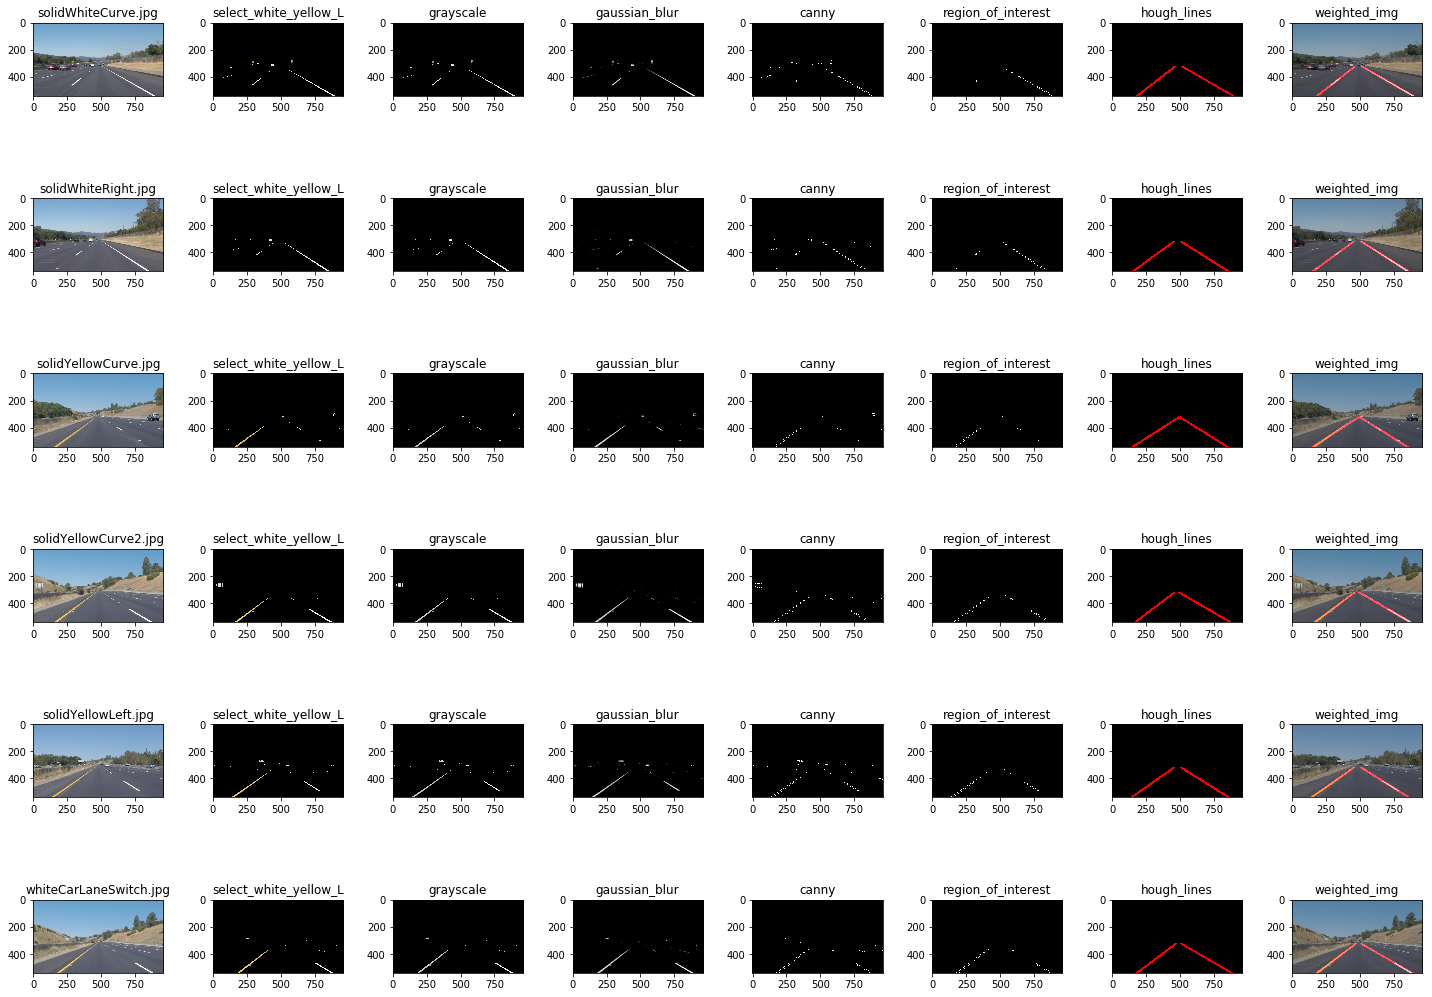

In [17]:
lane_detection(True)

## Video processing + Optional Challange

In [5]:
# process movie  printProcess = False 

lane_detection(printProcess=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:22<00:00, 29.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:07<00:00, 30.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:15<00:00, 15.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 



## Videos

In [ ]:
hf.show_videos_html("test_videos_output/solidYellowLeft.mp4")

In [ ]:
hf.show_videos_html("test_videos_output/solidWhiteRight.mp4")

In [7]:
hf.show_videos_html("test_videos_output/challenge.mp4")

AttributeError: module 'HELPERS.helper_funs' has no attribute 'show_videos_html'

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.
